In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_cuda import LocalCUDACluster

import cupy as cp
from ase.build import bulk
from abtem import FrozenPhonons, SMatrix, Potential, GridScan, AnnularDetector

import os
os.environ["MKL_NUM_THREADS"] = "1"

from abtem import config
config.set({'device': 'gpu'})
config.set({'lazy': True})

Runtime: 0.7 s per frozen phonon on 1 NVidia RTX 2080 Ti

In [2]:
cluster = LocalCUDACluster(memory_limit='10gb', n_workers=1)
client = Client(cluster)

C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\distributed\node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 62267 instead
  warnings.warn(
C:\Users\jacob\anaconda3\envs\dask-gpu\lib\site-packages\dask_cuda\utils.py:214: UserWarning: Cannot get CPU affinity for device with index 0, setting default affinity
  warnings.warn(
distributed.nanny - ERROR - Failed while trying to start worker process: strides is incompatible with shape of requested array and size of buffer
Task exception was never retrieved
future: <Task finished name='Task-20' coro=<_wrap_awaitable() done, defined at C:\Users\jacob\anaconda3\envs\dask-gpu\lib\asyncio\tasks.py:684> exception=ValueError('strides is incompatible with shape of requested array and size of buffer')>
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\dask-gpu\lib\asyncio\tasks.py", line 691, in _wrap_awaitable
    return (yield from awai

ValueError: strides is incompatible with shape of requested array and size of buffer

In [32]:
atoms = bulk('Si', 'diamond', a=5.43, cubic=True)
atoms *= (5, 5, 5)

In [45]:
# number of plane waves in each chunk
plane_wave_chunks = 100

frozen_phonons = FrozenPhonons(atoms, 64, {'Si': .1})

potential = Potential(frozen_phonons, 
                      gpts=1024,
                      projection='infinite', 
                      slice_thickness=2)

s_matrix = SMatrix(potential, energy=100e3, planewave_cutoff=20, chunks=300, interpolation=3, store_on_host=False)
scan = GridScan()

detectors = AnnularDetector(50, 150, ensemble_mean=True)

measurement = s_matrix.scan(scan=scan, detectors=detectors, distribute_scan=False, probes_per_reduction=1000, downsample='cutoff')

#measurement.compute(scheduler='single-threaded')
                         #positions_per_reduction=positions_per_reduction)

In [46]:
%%time
measurement.compute()

Wall time: 44.6 s


In [47]:
44.6 / 64

0.696875

(<AxesSubplot:xlabel='x [Å]', ylabel='y [Å]'>,
 <matplotlib.image.AxesImage at 0x26926079850>)

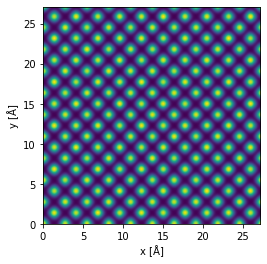

In [37]:
measurement.interpolate(.1).show()